In [91]:
import cv2
import urllib3
import numpy as np
import scipy

from PIL import Image

import imutils
from matplotlib import pyplot as plt

# Block 4. Feature detection, Image descriptors and BoVW

This lab explores the fundamental concepts of feature extraction and feature descriptors in computer vision. It delves into various feature detection techniques like Harris corner and LoG blob detectors, and descriptor methods like SIFT, SURF, and ORB. Additionally, the lab introduces the Bag of Visual Words model, demonstrating its application in image classification, particularly using a subset of the VOC dataset.

### Objectives:
1. **Implement Feature extraction methods**
  - **Implement Harris Corner Detector**: Understand and implement the Harris corner detection algorithm to identify corner features in images.
  - **Implement LoG Blob Detector**: Learn and apply the Laplacian of Gaussian method for blob detection in images.
2. **Implement Image feature descriptors** (Reusing part of the feature extraction code)
  - **Implement Normalized Color Histogram and Color Space Changes**: Explore color features by implementing normalized color histograms and understanding the impact of different color spaces.
  - **Use SIFT, SURF, and ORB**: Use these feature descriptors, analyze their strengths and weaknesses, and compare their performance.
3. **Provide a Pipeline for Bag of Words and Compute Results on Subset of VOC Dataset**: Develop a Bag of Visual Words model and test its efficacy in classifying images from a subset of the VOC dataset.

---

### Mandatory Questions:

1. Explain the principles behind corner detectors, specifically the Harris corner detection method. Why is it effective in identifying corners?
2. Discuss the main differences between edge detection and corner detection. Why are corners considered more robust features?
3. What are the limitations of the Harris corner detector in complex images?
4. Describe the Laplacian of Gaussian blob detector. How does it differ from edge detection?
5. Discuss the role of feature descriptors in object recognition.
6. Why are color histograms useful for image feature extraction? Describe the process of creating a normalized color histogram.
7. How does a change in color space affect feature extraction in images?
8. Explain the concepts of scale and rotation invariance in feature detection. For each algorithm (SIFT, SURF, and ORB), explain how they handle scale and rotation variations in images.
9. Compare SIFT, SURF, and ORB in terms of computational efficiency and accuracy.
10. What is the role of orientation assignment in the SIFT algorithm?
11. How does the ORB algorithm differ from SIFT and SURF in terms of feature matching?
12. How do feature descriptors contribute to the process of image stitching (for panorama images)?
13. Discuss the impact of varying lighting conditions on feature detection and description. How can these challenges be mitigated?
14. What are the key steps in constructing a Bag of Visual Words model? Explain each of them in detail.
15. In the context of the Bag of Visual Words model, explain the significance of feature quantization. Discuss on which steps it can be done and how it affects the results.


### Optional Deep Dive Questions:

1. Discuss the potential weaknesses of the LoG blob detector in real-world scenarios. Propose improvements.
2. Explore the potential of hybrid color spaces (combining properties of different color models) in improving the robustness of feature extraction for applications in varied lighting and environmental conditions.
3. Discuss the impact of varying image resolutions on the effectiveness of feature descriptors.
4. Discuss the limitations of current feature descriptors in handling occlusions and propose potential improvements.
5. Evaluate the performance of hybrid feature detectors that combine the properties of multiple algorithms (like SIFT and Harris). What are the potential benefits?
6. Analyze the role of feature extraction in content-based image retrieval systems. How do they impact the efficiency and accuracy of searches?
7. How might the Bag of Visual Words model be modified or extended to improve classification accuracy?
8. Consider the role of context in feature-based image classification. How might contextual information be incorporated into the Bag of Visual Words model?


### Exercise 1: Harris Corner Detector Implementation
**Objective**:

Implement the Harris Corner Detection algorithm to identify corner features in images.

**Guideline**:
- Load image.
- Implement the basic Harris Corner Detection algorithm.
- Apply the algorithm to the images and visualize the detected corners.
- Explore the impact of parameter changes on detection quality.
- (Optional) Implement the Harris-Laplace and the Harris-Affine improvments and compare the pros and cons of each version

**Expected Results**:
- A working Harris Corner Detection implementation.
- Visualization of corner detection in various images.

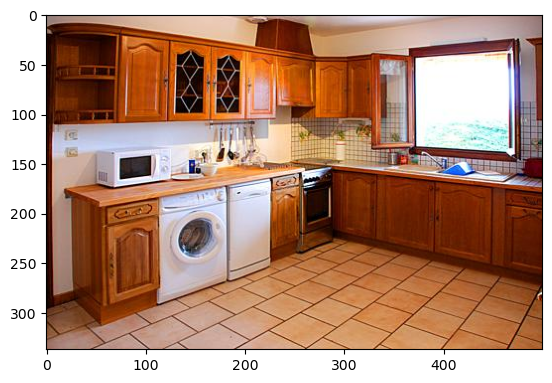

In [92]:
img_rgb = cv2.imread("dataset/train/kitchen/sun_agfmsmojwptjoava.jpg")
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

#### Implementation of Harris corner detection

In [93]:
def harris_corner_detection(image: np.ndarray,
							ksize: int=3,
							k: float=0.04,
							thresh: float=0.01,
							dilate: bool=False,
							return_R: bool=False,
							return_S: bool=False) -> np.ndarray:
	"""
	Harris Corner Detection algorithm.

	# Parameters
	image: Input image
	ksize: Size of the Sobel kernel
	k: Harris detector free parameter
	thresh: Threshold for detecting corners

	# Returns
	output: Image with corners marked
	if return_R: R matrix
	if return_S: Sxx, Sxy, Syy derivatives
	"""
	img = image.copy().astype(np.float32)
	# If the input image is in color, convert it to grayscale
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# First derivatives
	Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
	Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)

	# Products of derivatives
	Ixx = Ix ** 2
	Ixy = Ix * Iy
	Iyy = Iy ** 2

	# Gaussian smoothing
	Sxx = cv2.GaussianBlur(Ixx, (ksize, ksize), 1)
	Sxy = cv2.GaussianBlur(Ixy, (ksize, ksize), 1)
	Syy = cv2.GaussianBlur(Iyy, (ksize, ksize), 1)

	# # find eigenvalues with numpy
	# eig1 = np.zeros_like(Sxx)
	# eig2 = np.zeros_like(Sxx)

	# for i in range(Sxx.shape[0]):
	# 	for j in range(Sxx.shape[1]):
	# 		M = np.array([[Sxx[i, j], Ixy[i, j]], [Sxy[i, j], Syy[i, j]]])
	# 		# Compute eigenvalues
	# 		eigvals = np.linalg.eigvals(M)
	# 		# Store them
	# 		eig1[i, j] = eigvals[0].real
	# 		eig2[i, j] = eigvals[1].real
	
	# det = eig1 * eig2
	# trace = eig1 + eig2

	# Another way to directly compute det and trace
	det = (Sxx * Syy) - (Sxy ** 2)
	trace = Sxx + Syy

	R = det - k * (trace ** 2)

	# Threshold for an optimal value
	R = (R > thresh * R.max())
	R = R.astype(np.uint8)

	if dilate:
		R = cv2.dilate(R, np.ones((3, 3)))

	# Marking corners on the image
	output = image.copy()
	if output.ndim == 3:  # RGB
		output[R > 0] = [255, 0, 0]  # Red color for corners
	else:  # Grayscale
		output[R > 0] = 255  # White color for corners

	ret = [output]
	if return_R:
		ret.append(R)
	if return_S:
		ret.append(Sxx)
		ret.append(Sxy)
		ret.append(Syy)
	if len(ret) == 1:
		return ret[0]
	return ret

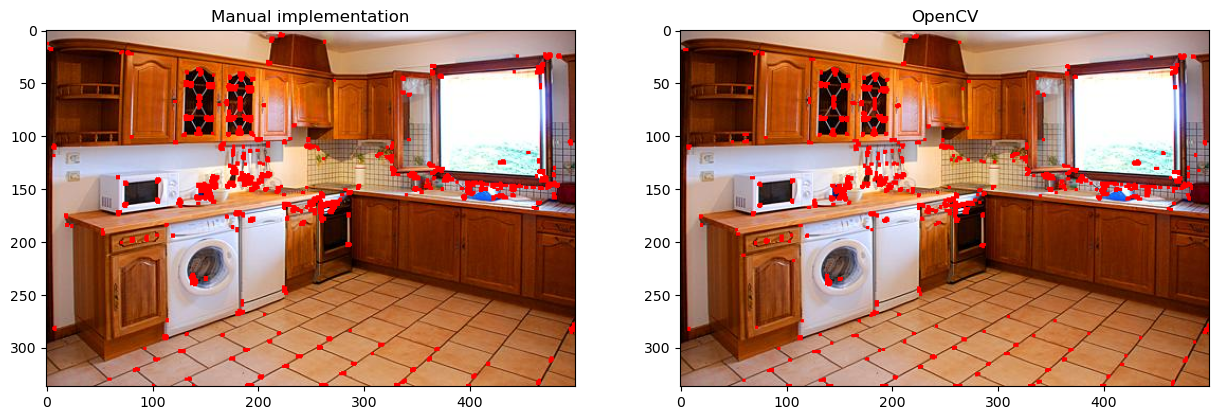

In [97]:
# Manual implementation
res = harris_corner_detection(img_rgb, ksize=3, k=0.04, thresh=0.01, dilate=True)

# OpenCV implementation
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
res_cv2 = cv2.cornerHarris(img_gray.copy(), blockSize=2, ksize=3, k=0.04)
res_cv2 = cv2.dilate(res_cv2, np.ones((3, 3)))
res_rgb_cv2 = img_rgb.copy()
res_rgb_cv2[res_cv2 > 0.01 * res_cv2.max()] = [255, 0, 0]

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(res)
ax[0].set_title("Manual implementation")
ax[1].imshow(res_rgb_cv2)
ax[1].set_title("OpenCV")
plt.show()

#### Exploration of the impact of different parameters

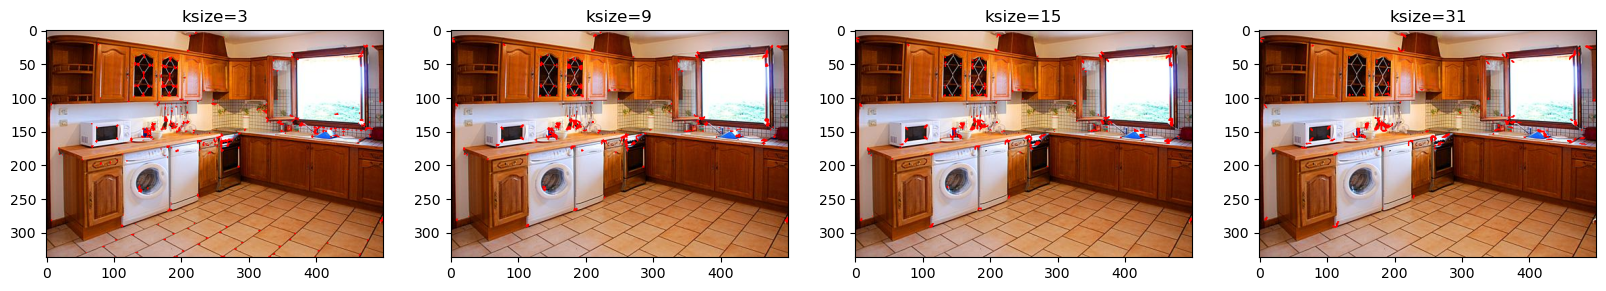

In [98]:
ksizes = [3, 9, 15, 31]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, ksize in enumerate(ksizes):
	ax[i].imshow(harris_corner_detection(img_rgb, ksize=ksize))
	ax[i].set_title(f"ksize={ksize}")
plt.show()

By increasing the kernel size (of the Sobel operator), the accuracy of detection of corners decreases, and small corners are less detected. Observe that with ksize=9, corners of the tiles in the floor are no longer detected.

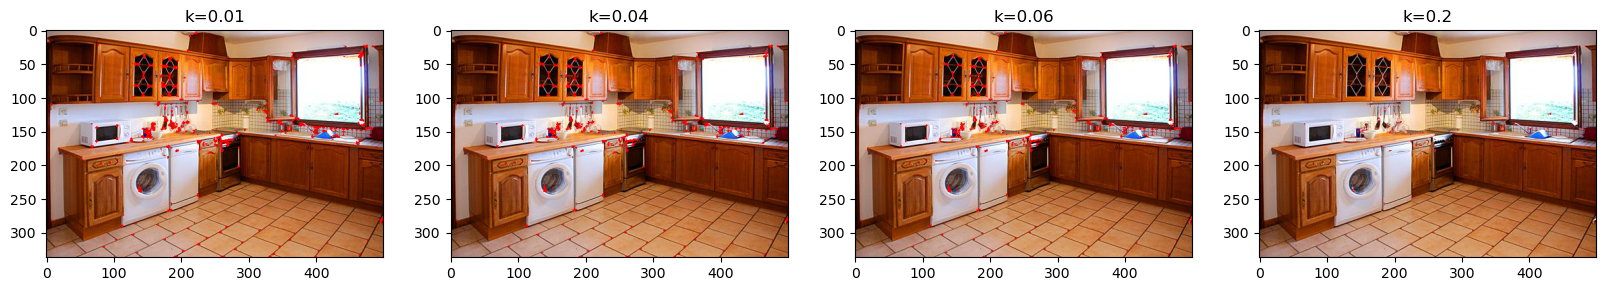

In [99]:
ks = [0.01, 0.04, 0.06, 0.2]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, k in enumerate(ks):
	ax[i].imshow(harris_corner_detection(img_rgb, k=k))
	ax[i].set_title(f"k={k}")
plt.show()

Low values of k seem to decrease the precision of which each corner is detected, meaning that the ambiguity of a specific pixel in a neighborhood being a corner increases, so we have more pixels that represent a same corner. High values increase the precision, but at some point some corners stop being detected. Optimal values lay between 0.04 and 0.06. 

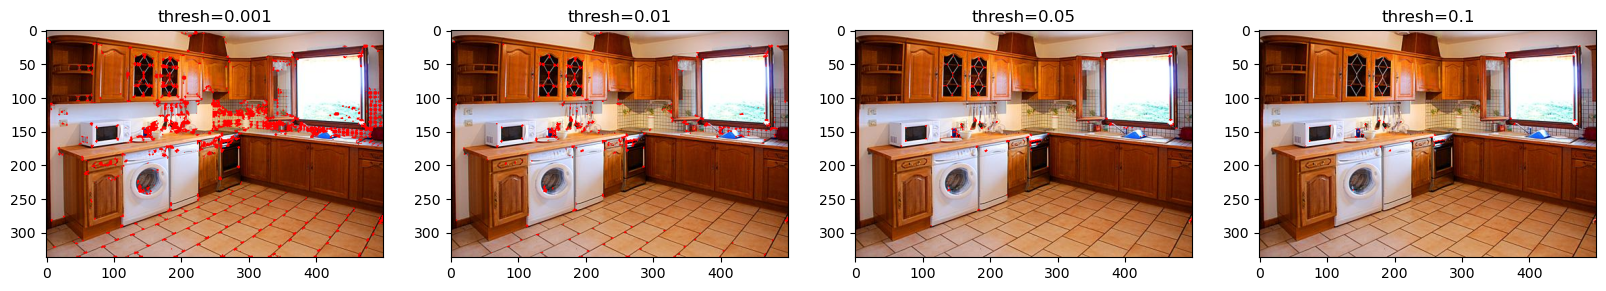

In [100]:
threshs = [0.001, 0.01, 0.05, 0.1]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, thresh in enumerate(threshs):
	ax[i].imshow(harris_corner_detection(img_rgb, thresh=thresh))
	ax[i].set_title(f"thresh={thresh}")
plt.show()

The threshold has a similar effect to k, but a different meaning. The threshold determines above which value of R should a pixel be considered a corner. The higher the threshold, the less pixels will be considered corners. But if too low, we might have false corners detected.

#### Harris-Laplace
https://perception.inrialpes.fr/Publications/2002/Mik02/Mikolajczyk_these2002.pdf

In [101]:
def harris_laplace_corner_detection(image: np.ndarray,
									num_scales: int = 5,
									ksize: int = 3,
									k: float = 0.04,
									harris_thresh: float = 0.01,
									log_thresh: float = 0.01,
									dilate: bool = False,
									overlap: float = 0.1,
									return_R: bool = False,
									return_S: bool = False) -> list:
	"""
	Harris-Laplace Corner Detector.

	Parameters:
	image: Input image
	num_scales: Number of scales to consider in scale-space
	ksize: Size of the Sobel kernel
	k: Harris detector free parameter
	harris_thresh: Threshold for Harris corner detection
	log_thresh: Threshold for Laplacian of Gaussian
	dilate: Whether to dilate the corner points
	overlap: Maximum overlap between keypoints (0.0 - 1.0)

	Returns:
	output: Image with corners marked
	"""

	img = image.copy()
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Generate scale-space
	# Note: linspace generates a list of sigma values (0.5, 1, 1.5...) and ksize of (0, 0) means that
	# the function will automatically compute the kernel size based on sigma
	scale_space = [cv2.GaussianBlur(img, (0, 0), sigma) for sigma in np.linspace(1, 3, num_scales)]
	
	# Harris at each scale
	harris = [harris_corner_detection(scale, ksize, k, harris_thresh, dilate, True, True) for scale in scale_space]
	_, Rs, Sxxs, Sxys, Syys = zip(*harris)

	# Laplacian of Gaussian
	# Note: squaring the Laplacian enhances contrast and avoids negatives
	log_images = [cv2.Laplacian(scale, cv2.CV_64F) ** 2 for scale in scale_space]

	# Maximum LoG across scales
	max_log_image = np.amax(log_images, axis=0)
	max_log_scale = np.argmax(log_images, axis=0)

	# Maximum R across scales
	max_R_image = np.amax(Rs, axis=0)

	# Apply thresholds
	is_max = max_log_image > log_thresh
	corner_points = np.where((max_R_image > 0) & is_max)

	# Generate keypoints for each corner detected
	keypoints = [cv2.KeyPoint(float(x), float(y), size=float(max_log_scale[y, x]+1)*10) for y, x in zip(*corner_points)]

	# Filter keypoints that are too close to each other
	filtered_keypoints = []
	for keypoint in keypoints:
		if all(cv2.KeyPoint_overlap(keypoint, other) < overlap for other in filtered_keypoints):
			filtered_keypoints.append(keypoint)

	ret = [filtered_keypoints]
	if return_R:
		ret.append(max_R_image)
	if return_S:
		ret.append(Sxxs)
		ret.append(Sxys)
		ret.append(Syys)
	if len(ret) == 1:
		return ret[0]
	return ret

def draw_keypoints(image: np.ndarray, keypoints: list, scale_circles: bool=True) -> np.ndarray:
	"""
	Draw keypoints on image.

	# Parameters
	image: Input image
	keypoints: List of keypoints

	# Returns
	output: Image with keypoints drawn
	"""
	if scale_circles:
		return cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
	else:
		return cv2.drawKeypoints(image, keypoints, None, color=(255, 0, 0))

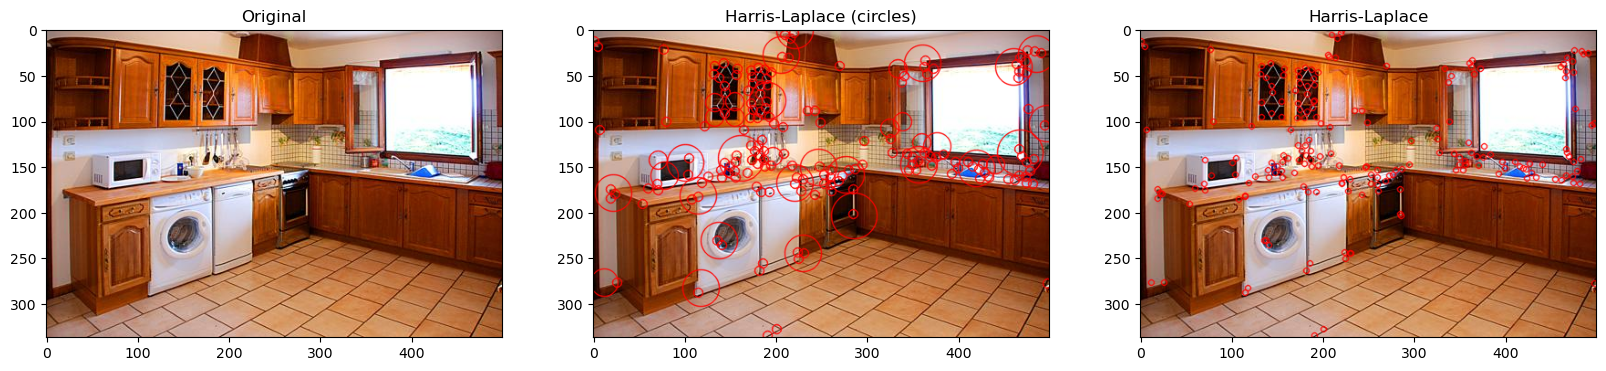

In [102]:
keypoints = harris_laplace_corner_detection(img_rgb, num_scales=5, ksize=3, k=0.04, harris_thresh=0.01, log_thresh=10)
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_rgb)
ax[0].set_title("Original")
ax[1].imshow(draw_keypoints(img_rgb, keypoints))
ax[1].set_title("Harris-Laplace (circles)")
ax[2].imshow(draw_keypoints(img_rgb, keypoints, scale_circles=False))
ax[2].set_title("Harris-Laplace")
plt.show()

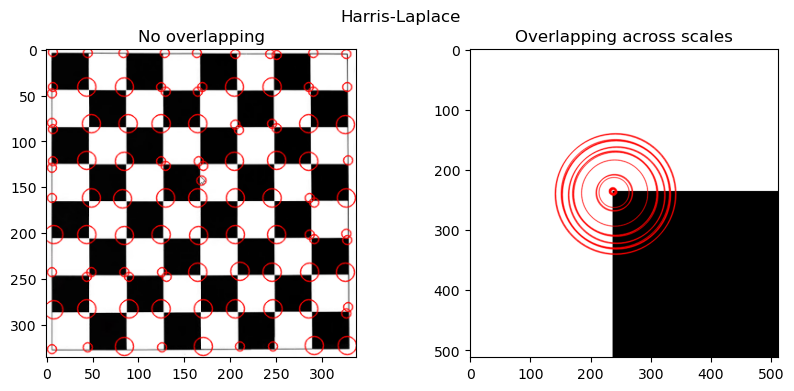

In [103]:
img_rgb2 = cv2.imread("extras/squares.png")
img_rgb2 = cv2.cvtColor(img_rgb2, cv2.COLOR_BGR2RGB)
img_rgb3 = cv2.imread("extras/square.png")
img_rgb3 = cv2.cvtColor(img_rgb3, cv2.COLOR_BGR2RGB)
keypoints2 = harris_laplace_corner_detection(img_rgb2, num_scales=5, ksize=3, k=0.04, harris_thresh=0.01, log_thresh=500)
keypoints3 = harris_laplace_corner_detection(img_rgb3, num_scales=20, ksize=3, k=0.04, harris_thresh=0.01, log_thresh=0, overlap=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(draw_keypoints(img_rgb2, keypoints2))
ax[1].imshow(draw_keypoints(img_rgb3, keypoints3))
ax[0].set_title("No overlapping")
ax[1].set_title("Overlapping across scales")
fig.suptitle("Harris-Laplace")
plt.show()

#### Comparison between Haris and Harris-Laplace
Compared deeply in the report

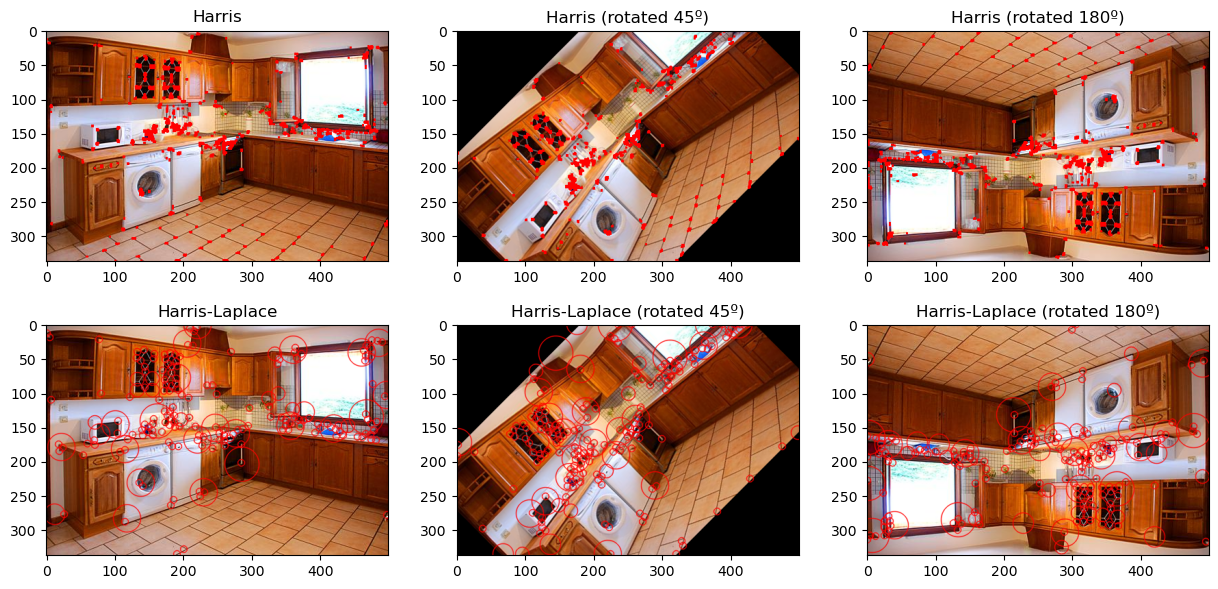

In [109]:
# Rotate image
img_rgb_rot45 = imutils.rotate(img_rgb, 45)
img_rgb_rot180 = imutils.rotate(img_rgb, 180)
harris = harris_corner_detection(img_rgb, dilate=True)
harris_rot45 = harris_corner_detection(img_rgb_rot45, dilate=True)
harris_rot180 = harris_corner_detection(img_rgb_rot180, dilate=True)
harris_lap = harris_laplace_corner_detection(img_rgb)
harris_lap_rot45 = harris_laplace_corner_detection(img_rgb_rot45)
harris_lap_rot180 = harris_laplace_corner_detection(img_rgb_rot180)
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax[0, 0].imshow(harris)
ax[0, 0].set_title("Harris")
ax[0, 1].imshow(harris_rot45)
ax[0, 1].set_title("Harris (rotated 45º)")
ax[0, 2].imshow(harris_rot180)
ax[0, 2].set_title("Harris (rotated 180º)")
ax[1, 0].imshow(draw_keypoints(img_rgb, harris_lap))
ax[1, 0].set_title("Harris-Laplace")
ax[1, 1].imshow(draw_keypoints(img_rgb_rot45, harris_lap_rot45))
ax[1, 1].set_title("Harris-Laplace (rotated 45º)")
ax[1, 2].imshow(draw_keypoints(img_rgb_rot180, harris_lap_rot180))
ax[1, 2].set_title("Harris-Laplace (rotated 180º)")
plt.show()


### Exercise 2: LoG Blob Detector Implementation
**Objective**:

Develop and apply the LoG method for blob detection in images, understanding its application in feature extraction.

**Guideline**:
- Select diverse images for blob detection.
- Implement the LoG Blob Detector.
- Analyze the LoG method's effectiveness.
- Compare LoG with other blob detection methods.
- (Optional) Implement your own version of other methods (DoG, DoH, ...) or design your own

**Expected Results**:
- Documented LoG Blob Detector implementation.
- Comparative analysis of blob detection results.
- Evaluation of method effectiveness and limitations.



### Exercise 3: Normalized Color Histogram and Color Space Changes
**Objective**:
Implement normalized color histograms and explore color space transformations' impact on feature extraction.

**Guideline**:
- Implement normalized color histograms.
- Transform images into different color spaces and generate histograms.
- Analyze the impact of color space changes.

**Expected Results**:
- Color histograms in various spaces for a set of images.
- Comparative analysis on color space impact.
- Discussion on color in feature extraction and analysis.



### Exercise 4: Implementation and Analysis of SIFT, SURF, and ORB
**Objective**:
Implement and analyze SIFT, SURF, and ORB feature descriptors (use opencv implementations), understanding their pros and cons.

**Guideline**:
- Select a diverse image dataset.
- Implement SIFT and ORB algorithms. (Since SURF is patented, is optionally in the comparions)
- Apply these methods to some images.

**Expected Results**:
- Implementations of SIFT, ORB (and SURF).
- Hyperparameter analysis of each algorithm.
- Comparision of the methods

### (Optional) Exercise 4.5: Implement other image descriptor methods (motion, shape, ...)


### Exercise 5: Bag of Visual Words Pipeline and VOC Dataset Analysis
**Objective**:
Develop a BoVW model and apply it to classify images from the VOC dataset, focusing on the BoVW approach.

**Guideline**:
- Load the VOC dataset.
- Implement the BoVW model.
- Apply the model to the dataset for classification.
- Evaluate the model's performance.

**Expected Results**:
- Implementation of the Bag of Visual Words model.
- Application of the model for image classification.
- Evaluation of the model's performance.

**Optional Enhancements**:
- Experiment with different clustering algorithms for codebook generation in the BoVW model.

### Step 1: Data Loading
- **Objective**: Load images from each class into a format suitable for processing.
- **Guide**: Use a library like OpenCV or PIL in Python to load images. Iterate over the folders, loading each image and storing it with its class label.

### Step 2: Feature Extraction
- **Objective**: Extract features from each image to represent its content.
- **Guide**: Apply a feature descriptor to each image. This transforms the image into a set of features. Examples can be SIFT, SURF, Color histogram, etc

### Step 3: Building the Vocabulary (Codebook)
- **Objective**: Create a vocabulary of visual words (features) that represents the dataset.
- **Guide**: Cluster the extracted features across all images using any clustering algorithm. Each cluster center is a visual word.

### Step 4: Feature Encoding
- **Objective**: Encode each image as a frequency histogram of visual words.
- **Guide**: For each image, count how many features fall into each cluster (visual word) and create a histogram.

### Step 5: Classifier Training
- **Objective**: Train a machine learning model to classify the images.
- **Guide**: Use the histograms as input features for a classifier. Any supervised classifier can be used (SVM, Random Forest, KNN, Neural nets, ...)

### Step 6: Model Evaluation
- **Objective**: Evaluate the performance of the classifier.
- **Guide**: Use a confusion matrix to visualize the performance and extract metrics.